In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
from scipy.signal import butter, filtfilt
from numpy.linalg import inv
import warnings
import scienceplots
import seaborn as sns
import polars as pl
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import matplotlib.lines as mlines

warnings.filterwarnings("ignore")
# seaborn-v0_8-bright
plt.style.use(["ggplot", "science", "grid", "notebook"])
# Shades of blue
PRIMARY = "#0072b2"
PRIMARY_DARK = "#000080"
# Shades of red
SECONDARY = "#a60628"
SECONDARY_DARK = "#79011B"
# Shades of green
TERCIARY = "#228b22"
TERCIARY_DARK = "#556b2f"
# Shades of yellow
ALTERNATIVE = "#edb230"
ALTERNATIVE_DARK = "#e77728"
# Shades of black
TEXT_COLOR = "#212121"
plt.rc("font", family="Verdana")
FONT_SIZE = 16
LABEL_SIZE = 12
PARAM_SIZE = 14
VMIN = 6000
VMAX = 17000

plt.rcParams.update(
    {
        "axes.labelsize": LABEL_SIZE,
        "axes.titlesize": FONT_SIZE,
        "xtick.labelsize": LABEL_SIZE,
        "ytick.labelsize": LABEL_SIZE,
        "text.color": TEXT_COLOR,
        "axes.labelcolor": TEXT_COLOR,
        "axes.edgecolor": TEXT_COLOR,
        "xtick.color": TEXT_COLOR,
        "ytick.color": TEXT_COLOR,
        # "figure.facecolor": "white",
        # "axes.facecolor": "white",
    }
)

In [22]:
df_numpy = np.load('Uncompressed/inversion_data.npy')
df = pl.DataFrame({
    'imp_org': df_numpy[:, 0],
    'imp_back': df_numpy[:, 1],
    'ricker_ML': df_numpy[:, 2],
    'butter_ML': df_numpy[:, 3],
    'ricker_SS': df_numpy[:, 4],
    'butter_SS': df_numpy[:, 5]
})
shape = (256, 256, 256)

imp_30hz = df["imp_org"].to_numpy().reshape(shape)
imp_back = df["imp_back"].to_numpy().reshape(shape)
ricker_max_likelihood = df["ricker_ML"].to_numpy().reshape(shape)
butter_max_likelihood = df["butter_ML"].to_numpy().reshape(shape)
ricker_sparse_spike = df["ricker_SS"].to_numpy().reshape(shape)
butter_sparse_spike = df["butter_SS"].to_numpy().reshape(shape)

In [23]:
residuo_ml_ricker = df["imp_org"] - df["ricker_ML"]
residuo_ml_butter = df["imp_org"] - df["butter_ML"]
residuo_ss_ricker = df["imp_org"] - df["ricker_SS"]
residuo_ss_butter = df["imp_org"] - df["butter_SS"]

In [24]:
# Global variables
# Used in most cases

nx, ny, nz = imp_30hz.shape

In [25]:
butter_max_likelihood.shape

(256, 256, 256)

# Traço Sísmico

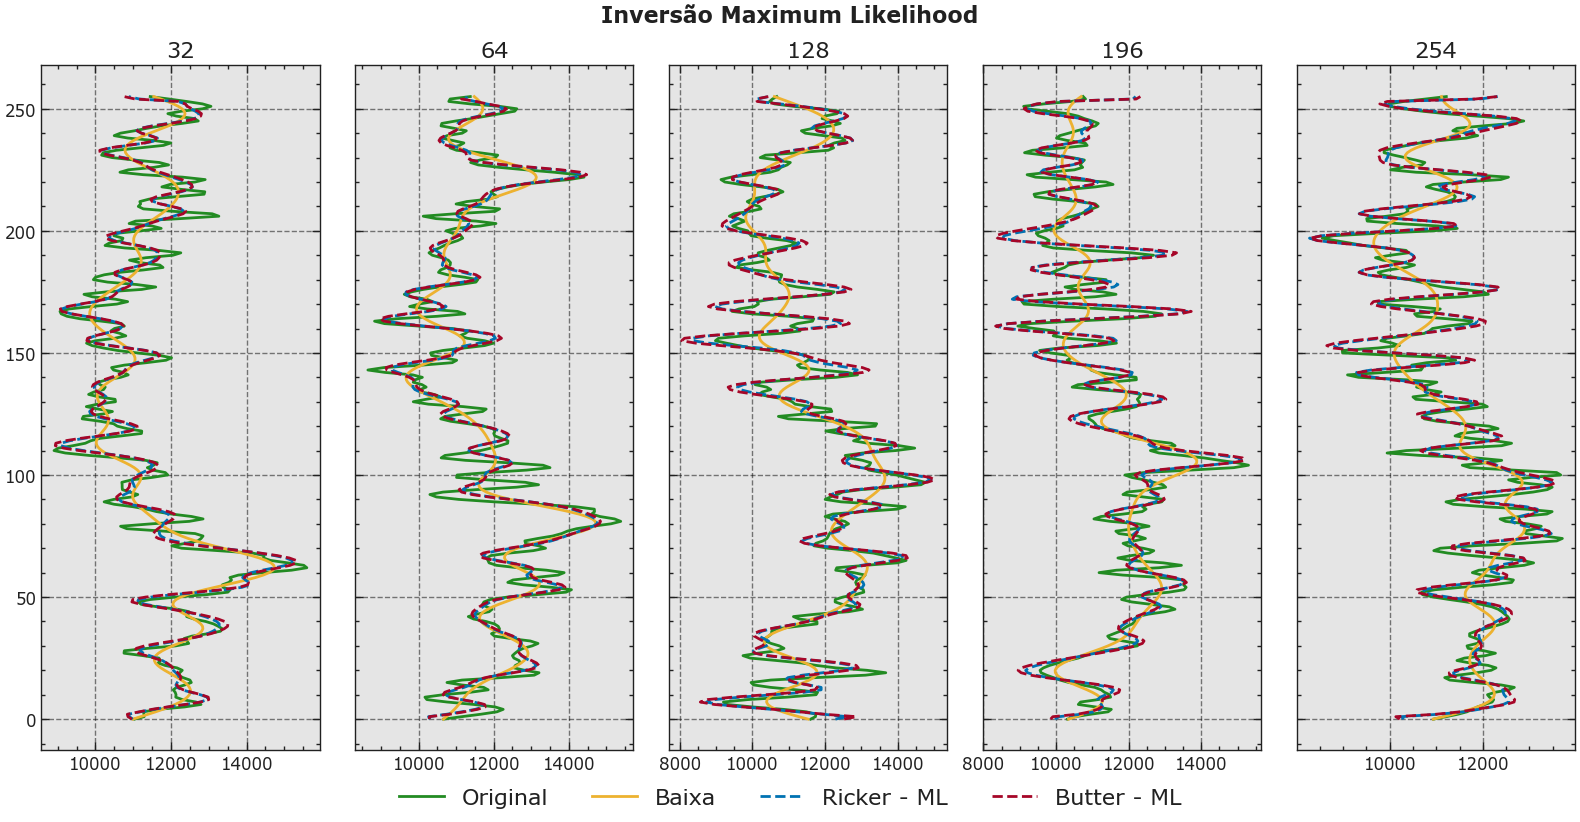

In [26]:
# 32, 64, 128, 196, 256
traco = np.arange(0, 256, 1)
SECTION = 128
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 8))

fig.suptitle("Inversão Maximum Likelihood", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

indices = [32, 64, 128, 196, 254]
for i, ax in enumerate(axs):
    ax.plot(imp_30hz[indices[i], SECTION, :].T, traco,  label='Original', color=TERCIARY)
    ax.plot(imp_back[indices[i], SECTION, :].T, traco,  label='Baixa', color=ALTERNATIVE)
    ax.plot(ricker_max_likelihood[indices[i], SECTION, :].T, traco,"--", label='Ricker - ML', color=PRIMARY)
    ax.plot(butter_max_likelihood[indices[i], SECTION, :].T, traco,"--", label='Butter - ML', color=SECONDARY)
    #ax.grid()
    ax.set_title(f'{indices[i]}')

fig.tight_layout()

# Adiciona uma única legenda para toda a figura
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=False)

plt.show()

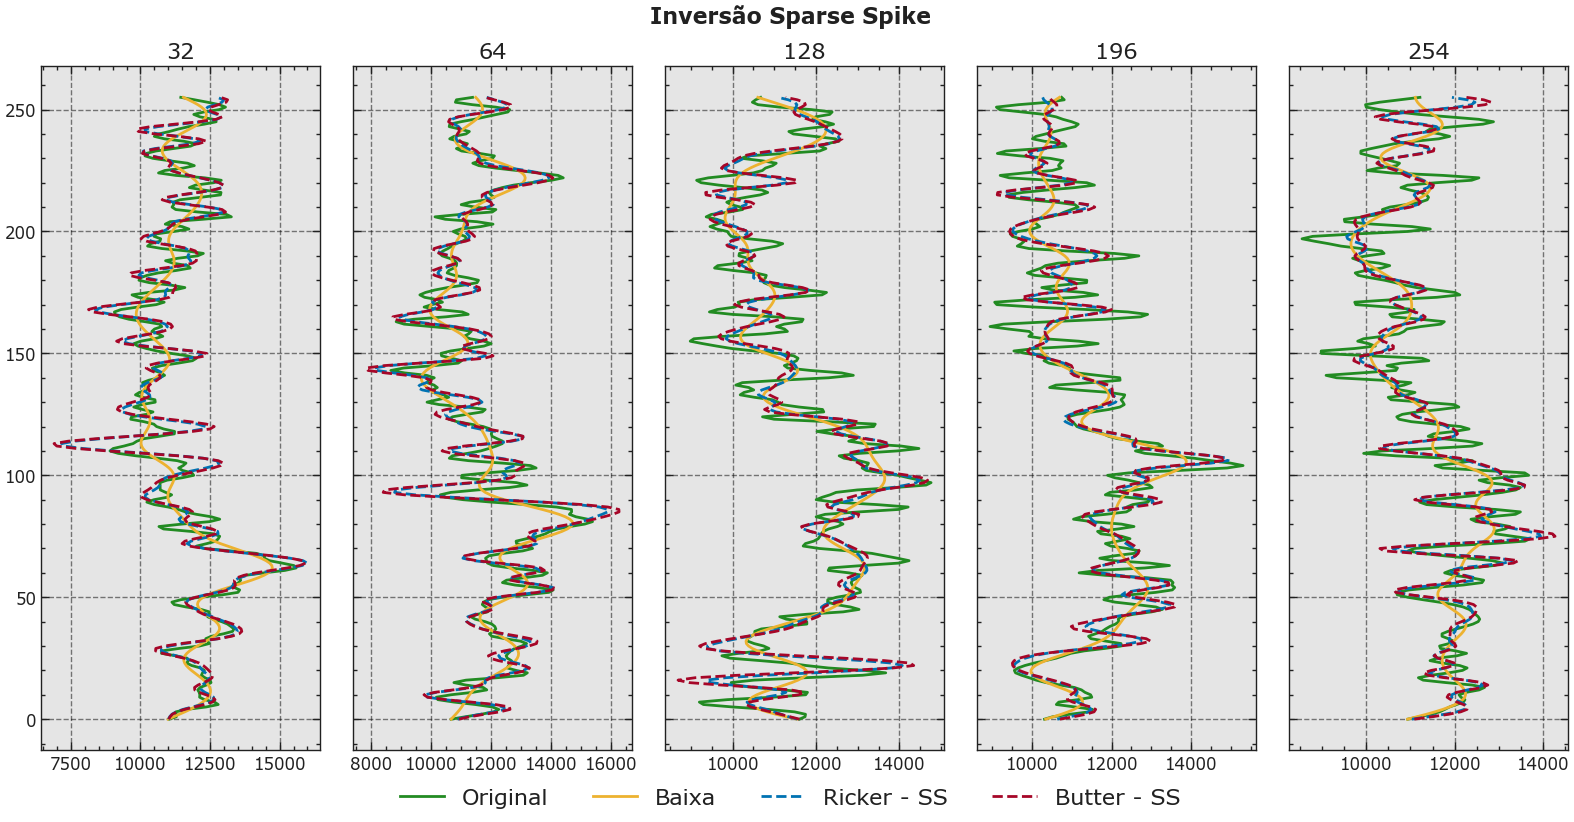

In [27]:
# 32, 64, 128, 196, 256
traco = np.arange(0, 256, 1)
SECTION = 128
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 8))

fig.suptitle("Inversão Sparse Spike", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

indices = [32, 64, 128, 196, 254]
for i, ax in enumerate(axs):
    ax.plot(imp_30hz[indices[i], SECTION, :].T, traco,  label='Original', color=TERCIARY)
    ax.plot(imp_back[indices[i], SECTION, :].T, traco,  label='Baixa', color=ALTERNATIVE)
    ax.plot(ricker_sparse_spike[indices[i], SECTION, :].T, traco,"--", label='Ricker - SS', color=PRIMARY)
    ax.plot(butter_sparse_spike[indices[i], SECTION, :].T, traco,"--", label='Butter - SS', color=SECONDARY)
    #ax.grid()
    ax.set_title(f'{indices[i]}')

fig.tight_layout()

# Adiciona uma única legenda para toda a figura
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=False)

plt.show()

# MAPE

$$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_{i} - {p}_{i}}{y_{i}} \right| $$

## Maximum Likelihood

In [28]:
# imp_30hz, ricker_sparse_spike, butter_sparse_spike

ml_mape_ricker_plot = np.zeros((nx))
ml_mape_butter_plot = np.zeros((nx))
ml_mape_ricker = np.zeros((nx, ny, nz))
ml_mape_butter = np.zeros((nx, ny, nz))


for ix in range(nx):
    ml_mape_ricker_plot[ix] = np.mean(np.abs((imp_30hz[ix, 128, :] - ricker_max_likelihood[ix, 128, :]) / imp_30hz[ix, 128, :]))
    ml_mape_butter_plot[ix] = np.mean(np.abs((imp_30hz[ix, 128, :] - butter_max_likelihood[ix, 128, :]) / imp_30hz[ix, 128, :]))
    for iy in range(ny):
        ml_mape_ricker[ix, iy, :] = np.mean(np.abs((imp_30hz[ix, iy, :] - ricker_max_likelihood[ix, iy, :]) / imp_30hz[ix, iy, :]))
        ml_mape_butter[ix, iy, :] = np.mean(np.abs((imp_30hz[ix, iy, :] - butter_max_likelihood[ix, iy, :]) / imp_30hz[ix, iy, :]))

# Calculate the mean and convert to percentags
ml_mape_ricker_plot *= 100
ml_mape_butter_plot *= 100

ml_mape_ricker *= 100
ml_mape_butter *= 100

print(f"Max Likelihood - Ricker é: {np.mean(ml_mape_ricker):.2f}%")
print(f"Max Likelihood - Butterworth é: {np.mean(ml_mape_butter):.2f}%")

Max Likelihood - Ricker é: 3.50%
Max Likelihood - Butterworth é: 3.75%


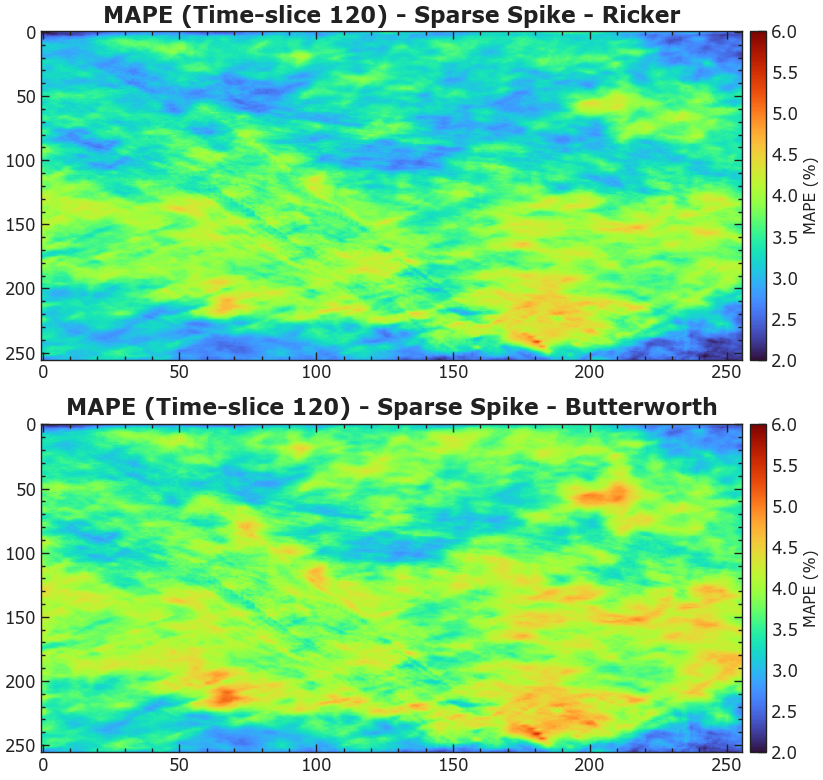

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 128

c = axs[0].imshow(
    ml_mape_ricker[:, :, 120].T,
    cmap="turbo",
    aspect="auto",
    vmin=2,
    vmax=6,
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("MAPE (%)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title(
    "MAPE (Time-slice 120) - Sparse Spike - Ricker",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)
# axs[0].set_ylabel("In-line")
# axs[0].set_xlabel("Cross-line")

c = axs[1].imshow(
    ml_mape_butter[:, :, 120].T,
    cmap="turbo",
    aspect="auto",
    vmin=2,
    vmax=6,
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("MAPE (%)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title(
    "MAPE (Time-slice 120) - Sparse Spike - Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
#plt.savefig("Figures/views/ml_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()

## Sparse-spike

In [31]:
# imp_30hz, ricker_sparse_spike, butter_sparse_spike
ss_mape_ricker_plot = np.zeros((nx))
ss_mape_butter_plot = np.zeros((nx))
ss_mape_ricker = np.zeros((nx, ny, nz))
ss_mape_butter = np.zeros((nx, ny, nz))

for ix in range(nx):
    ss_mape_ricker_plot[ix] = np.mean(np.abs((imp_30hz[ix, 128, :] - ricker_sparse_spike[ix, 128, :]) / imp_30hz[ix, 128, :]))
    ss_mape_butter_plot[ix] = np.mean(np.abs((imp_30hz[ix, 128, :] - butter_sparse_spike[ix, 128, :]) / imp_30hz[ix, 128, :]))
    for iy in range(ny):
        ss_mape_ricker[ix, iy, :] = np.mean(np.abs((imp_30hz[ix, iy, :] - ricker_sparse_spike[ix, iy, :]) / imp_30hz[ix, iy, :]))
        ss_mape_butter[ix, iy, :] = np.mean(np.abs((imp_30hz[ix, iy, :] - butter_sparse_spike[ix, iy, :]) / imp_30hz[ix, iy, :]))

# Calculate the mean and convert to percentags
ss_mape_ricker *= 100
ss_mape_butter *= 100
ss_mape_ricker_plot *= 100
ss_mape_butter_plot *= 100


print(f"Sparse Spike - Ricker é: {np.mean(ss_mape_ricker):.2f}%")
print(f"Sparse Spike - Butterworth é: {np.mean(ss_mape_butter):.2f}%")

Sparse Spike - Ricker é: 5.63%
Sparse Spike - Butterworth é: 6.04%


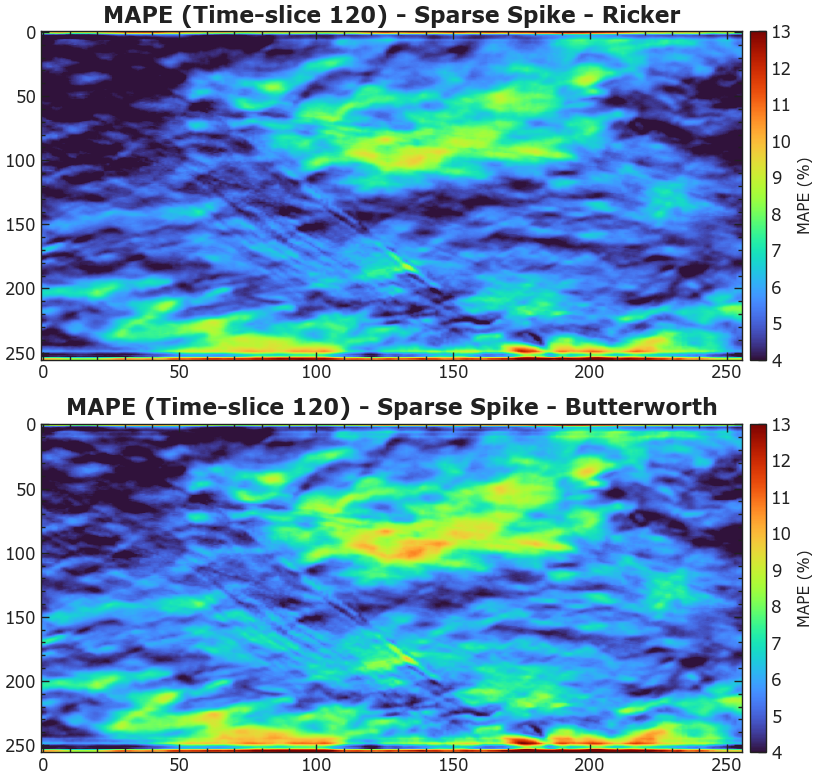

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 128

c = axs[0].imshow(
    ss_mape_ricker[:, :, 120].T,
    cmap="turbo",
    aspect="auto",
    vmin=4,
    vmax=13,
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("MAPE (%)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title(
    "MAPE (Time-slice 120) - Sparse Spike - Ricker",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)
# axs[0].set_ylabel("In-line")
# axs[0].set_xlabel("Cross-line")

c = axs[1].imshow(
    ss_mape_butter[:, :, 120].T,
    cmap="turbo",
    aspect="auto",
    vmin=4,
    vmax=13,
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("MAPE (%)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title(
    "MAPE (Time-slice 120) - Sparse Spike - Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
#plt.savefig("Figures/views/ml_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()

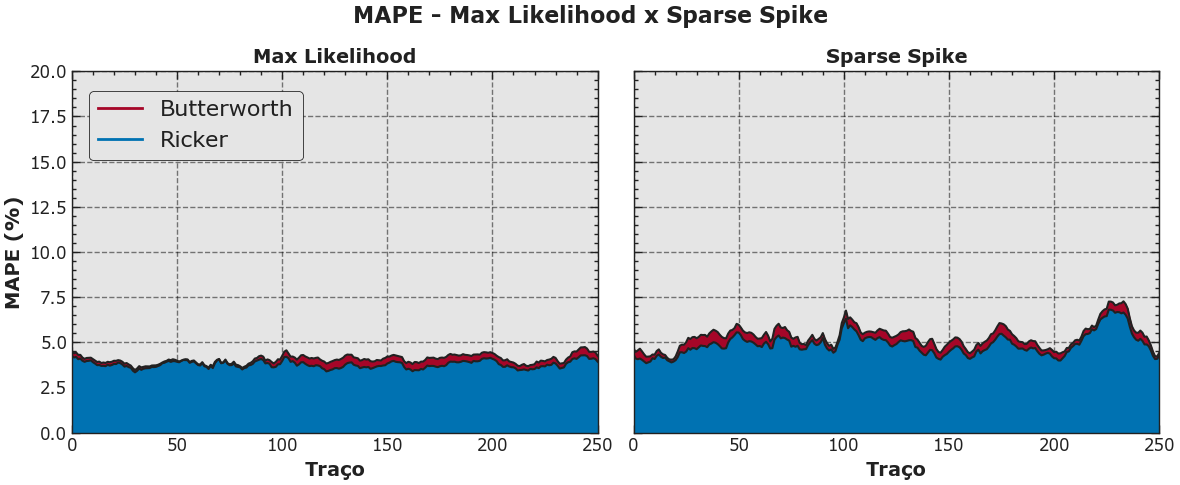

In [33]:
fig, (ml, ss) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 5))

fig.suptitle("MAPE - Max Likelihood x Sparse Spike", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

ml.plot(ml_mape_butter_plot, "-", label="Butterworth", ms=2, linewidth=1.5, color=TEXT_COLOR, markeredgecolor="black", markeredgewidth=0.5)
ml.fill_between(range(len(ml_mape_butter_plot)), ml_mape_butter_plot, color=SECONDARY)
ml.plot(ml_mape_ricker_plot, "-", label="Ricker", ms=2, linewidth=1.5, color=TEXT_COLOR, markeredgecolor="black", markeredgewidth=0.5)
ml.fill_between(range(len(ml_mape_ricker_plot)), ml_mape_ricker_plot, color=PRIMARY)
ml.set_title("Max Likelihood", fontsize=FONT_SIZE - 2, fontweight="bold", color=TEXT_COLOR)
ml.set_xlabel("Traço", fontsize=FONT_SIZE - 2, color=TEXT_COLOR, fontweight="bold")
ml.set_ylabel("MAPE (%)", fontsize=FONT_SIZE - 2, color=TEXT_COLOR, fontweight="bold")
ml.tick_params(axis="both", labelsize=PARAM_SIZE - 2)
ml.set_xlim(0, 250)  # Define os limites do eixo x

ss.plot(ss_mape_butter_plot, "-", label="Butterworth", ms=2, linewidth=1.5, color=TEXT_COLOR, markeredgecolor="black", markeredgewidth=0.5)
ss.fill_between(range(len(ss_mape_butter_plot)), ss_mape_butter_plot, color=SECONDARY)
ss.plot(ss_mape_ricker_plot, "-", label="Ricker", ms=2, linewidth=1.5, color=TEXT_COLOR, markeredgecolor="black", markeredgewidth=0.5)
ss.fill_between(range(len(ss_mape_ricker_plot)), ss_mape_ricker_plot, color=PRIMARY)
ss.set_title("Sparse Spike", fontsize=FONT_SIZE - 2, fontweight="bold", color=TEXT_COLOR)
ss.set_xlabel("Traço", fontsize=FONT_SIZE - 2, color=TEXT_COLOR, fontweight="bold")
ss.tick_params(axis="both", labelsize=PARAM_SIZE - 2)
ss.set_xlim(0, 250)  # Define os limites do eixo x

line_ricker = mlines.Line2D(
    [], [], color=SECONDARY, marker="_", markersize=15, label="Ricker"
)
line_butter = mlines.Line2D(
    [], [], color=PRIMARY, marker="_", markersize=15, label="Butterworth"
)


plt.ylim(0, 20)

_, labels = ml.get_legend_handles_labels()
fig.legend([line_ricker, line_butter], labels, loc='upper right', bbox_to_anchor=(0.27, 0.83), frameon=True, edgecolor='black', framealpha=1, fancybox=True)

plt.tight_layout()
plt.savefig("Figures/stats/MAPE_ml_ss", dpi=500, bbox_inches="tight")
plt.show()

# Correlação de Pearson

## Max Likelihood

In [34]:
from scipy.stats import pearsonr as pearson

ml_correlation_ricker = pearson(
    imp_30hz.flatten(), ricker_max_likelihood.flatten()
)[0]
ml_correlation_butter = pearson(
    imp_30hz.flatten(), butter_max_likelihood.flatten()
)[0]

print(
    f"ML - A correlação de Pearson global entre o original e a inversão de Ricker é: {ml_correlation_ricker:.2f}"
)
print(
    f"ML - A correlação de Pearson global entre o original e a inversão de Ricker é: {ml_correlation_butter:.2f}"
)

ML - A correlação de Pearson global entre o original e a inversão de Ricker é: 0.91
ML - A correlação de Pearson global entre o original e a inversão de Ricker é: 0.90


In [35]:
# 32, 64, 128, 196, 256
values = np.arange(0, 254, 1)

# section = 254
ml_correlation_or = np.zeros(len(values))
ml_correlation_ob = np.zeros(len(values))

for i, value in enumerate(values):

    ml_correlation_or[i] = pearson(
        imp_30hz[value, 128, :].flatten(),
        ricker_max_likelihood[value, 128, :].flatten(),
    )[0]

    ml_correlation_ob[i] = pearson(
        imp_30hz[value, 128, :].flatten(),
        butter_max_likelihood[value, 128, :].flatten(),
    )[0]

print(
    f"ML - A correlação de Pearson ao longo da cross-line 128 entre o original e a inversão de Ricker é: {np.mean(ml_correlation_or):.2f}"
)
print(
    f"ML - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Butterworth é: {np.mean(ml_correlation_ob):.2f}"
)

ML - A correlação de Pearson ao longo da cross-line 128 entre o original e a inversão de Ricker é: 0.91
ML - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Butterworth é: 0.90


## Sparse-spike

In [36]:
from scipy import stats

ss_correlation_ricker = pearson(
    imp_30hz.flatten(), ricker_sparse_spike.flatten()
)[0]
ss_correlation_butter = pearson(
    imp_30hz.flatten(), butter_sparse_spike.flatten()
)[0]

print(
    f"SS - A correlação de Pearson global entre o original e a inversão de Ricker é: {ss_correlation_ricker:.2f}"
)
print(
    f"SS - A correlação de Pearson global entre o original e a inversão de Ricker é: {ss_correlation_butter:.2f}"
)

SS - A correlação de Pearson global entre o original e a inversão de Ricker é: 0.75
SS - A correlação de Pearson global entre o original e a inversão de Ricker é: 0.72


In [37]:
# 32, 64, 128, 196, 256
values = np.arange(0, 254, 1)

# section = 254
ss_correlation_or = np.zeros(len(values))
ss_correlation_ob = np.zeros(len(values))

for i, value in enumerate(values):

    ss_correlation_or[i] = pearson(
        imp_30hz[value, 128, :].flatten(),
        ricker_sparse_spike[value, 128, :].flatten(),
    )[0]

    ss_correlation_ob[i] = pearson(
        imp_30hz[value, 128, :].flatten(),
        butter_sparse_spike[value, 128, :].flatten(),
    )[0]

print(
    f"SS - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Ricker é: {np.mean(ss_correlation_or):.2f}"
)
print(
    f"SS - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Butterworth é: {np.mean(ss_correlation_ob):.2f}"
)

SS - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Ricker é: 0.82
SS - A correlação de Pearson ao longo do traço 128 entre o original e a inversão de Butterworth é: 0.80


In [38]:
import pandas as pd

# Create a DataFrame with the values and ss_correlation_or
df = pd.DataFrame({
    'values': values,
    'ml_correlation_or': ml_correlation_or,
    "ml_correlation_ob": ml_correlation_ob,
    'ss_correlation_or': ss_correlation_or,
    'ss_correlation_ob': ss_correlation_ob
})

# Save the DataFrame to an Excel file
#df.to_excel('pearson.xlsx', index=False)

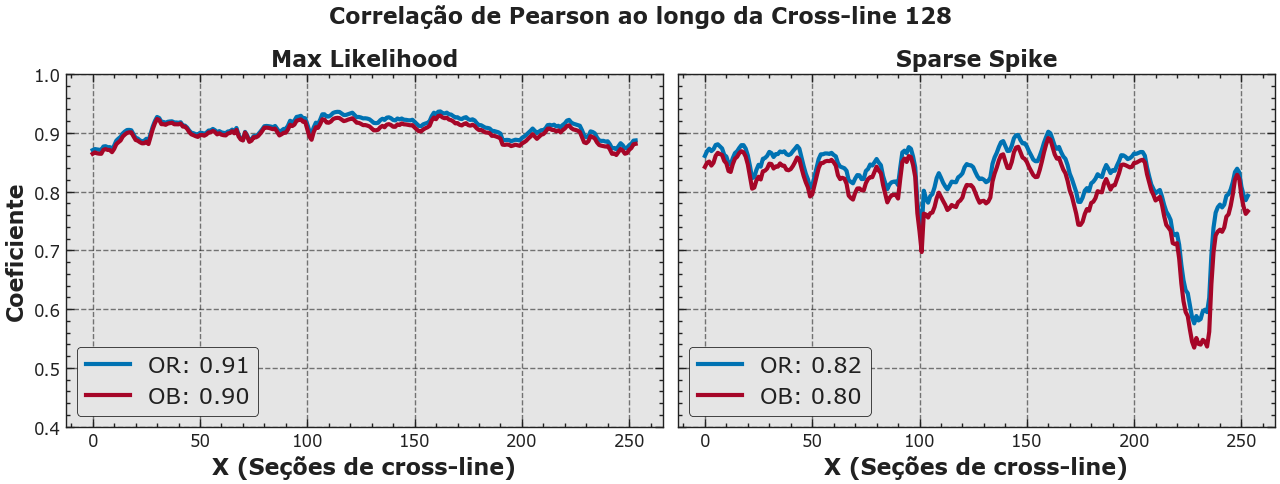

In [40]:
# Unificação das imagens
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 5))

fig.suptitle("Correlação de Pearson ao longo da Cross-line 128", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

axs[0].plot(values, ml_correlation_or, "-", label=f"OR: {np.mean(ml_correlation_or):.2f}", lw=3, color=PRIMARY)
axs[0].plot(values, ml_correlation_ob, "-", label=f"OB: {np.mean(ml_correlation_ob):.2f}", lw=3, color=SECONDARY)
axs[0].set_title("Max Likelihood", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
axs[0].legend(loc="lower left", fontsize=FONT_SIZE, frameon=True, edgecolor='black', framealpha=1, fancybox=True)
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].set_ylabel("Coeficiente", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
axs[0].set_xlabel("X (Seções de cross-line)", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")

axs[1].plot(values, ss_correlation_or, "-", label=f"OR: {np.mean(ss_correlation_or):.2f}", lw=3, color=PRIMARY)
axs[1].plot(values, ss_correlation_ob, "-", label=f"OB: {np.mean(ss_correlation_ob):.2f}", lw=3, color=SECONDARY)
axs[1].set_title("Sparse Spike", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
axs[1].legend(loc="lower left", fontsize=FONT_SIZE, frameon=True, edgecolor='black', framealpha=1, fancybox=True)
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].set_xlabel("X (Seções de cross-line)", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")


plt.ylim(0.4, 1)
plt.tight_layout()
plt.savefig("Figures/stats/correlacao_pearson_ml_ss.png", dpi=500, bbox_inches="tight")
plt.show()

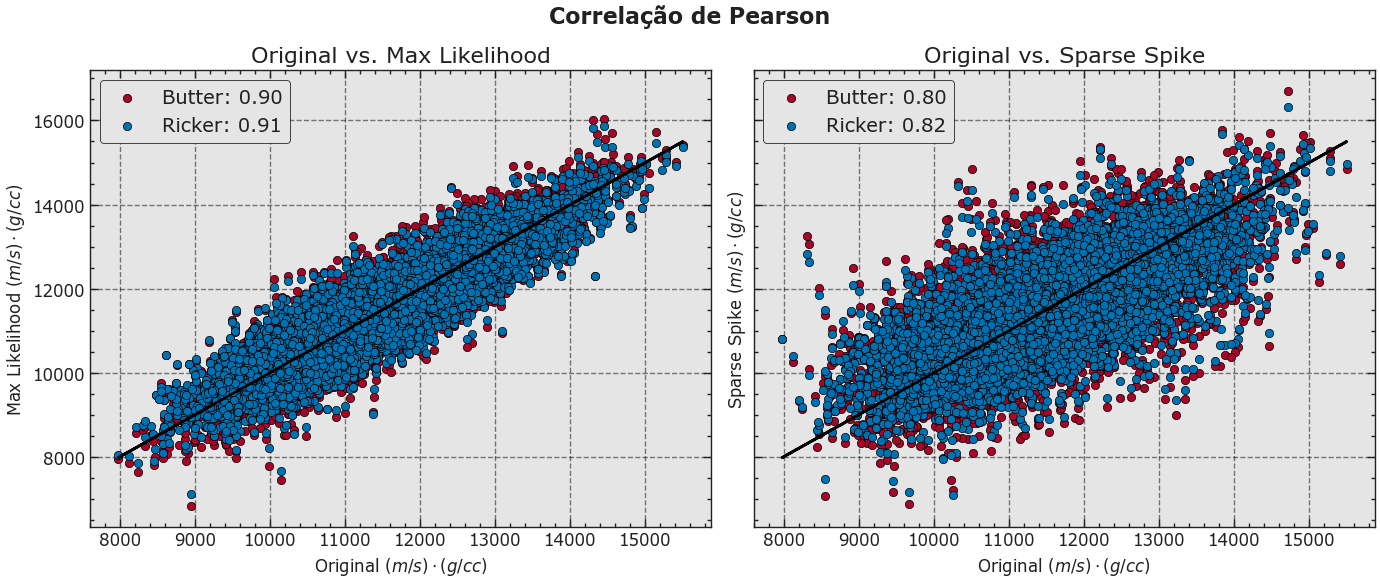

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Achatar os dados 3D para vetores 1D
imp_30hz_flat = imp_30hz.flatten()
ricker_max_likelihood_flat = ricker_max_likelihood.flatten()
butter_max_likelihood_flat = butter_max_likelihood.flatten()
ricker_sparse_spike_flat = ricker_sparse_spike.flatten()
butter_sparse_spike_flat = butter_sparse_spike.flatten()

# Amostrar uma fração dos dados para cálculo eficiente (ajuste a fração conforme necessário)
sample_fraction = 0.0005  # Exemplo: 0.05% dos dados
sample_indices = np.random.choice(len(imp_30hz_flat), size=int(len(imp_30hz_flat) * sample_fraction), replace=False)

# Dados amostrados
imp_org_sample = imp_30hz_flat[sample_indices]
ricker_ml_sample = ricker_max_likelihood_flat[sample_indices]
butter_ml_sample = butter_max_likelihood_flat[sample_indices]
ricker_ss_sample = ricker_sparse_spike_flat[sample_indices]
butter_ss_sample = butter_sparse_spike_flat[sample_indices]

# Calcular o coeficiente de Pearson na amostra
corr_or_ml, _ = pearsonr(imp_org_sample, ricker_ml_sample)
corr_ob_ml, _ = pearsonr(imp_org_sample, butter_ml_sample)

corr_or_ss, _ = pearsonr(imp_org_sample, ricker_ss_sample)
corr_ob_ss, _ = pearsonr(imp_org_sample, butter_ss_sample)

# Exibir a correlação em um gráfico de dispersão
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(14, 6))

fig.suptitle("Correlação de Pearson", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

axs[0].scatter(imp_org_sample, butter_ml_sample, color=SECONDARY,label=f'Butter: {np.mean(ml_correlation_ob):.2f}', edgecolor="black")
axs[0].scatter(imp_org_sample, ricker_ml_sample, color=PRIMARY,label=f'Ricker: {np.mean(ml_correlation_or):.2f}', edgecolor="black")
axs[0].plot(imp_org_sample, imp_org_sample, color="black")
axs[0].set_title("Original vs. Max Likelihood")
axs[0].set_xlabel(r"Original $(m/s)\cdot(g/cc)$")
axs[0].set_ylabel(r"Max Likelihood $(m/s)\cdot(g/cc)$")
axs[0].legend(fontsize=FONT_SIZE - 2, frameon=True, edgecolor='black', framealpha=1, fancybox=True)

axs[1].scatter(imp_org_sample, butter_ss_sample, color=SECONDARY, label=f'Butter: {np.mean(ss_correlation_ob):.2f}', edgecolor="black")
axs[1].scatter(imp_org_sample, ricker_ss_sample, color=PRIMARY, label=f'Ricker: {np.mean(ss_correlation_or):.2f}', edgecolor="black")
axs[1].plot(imp_org_sample, imp_org_sample, color="black")
axs[1].set_title("Original vs. Sparse Spike")
axs[1].set_xlabel(r"Original $(m/s)\cdot(g/cc)$")
axs[1].set_ylabel(r"Sparse Spike $(m/s)\cdot(g/cc)$")
axs[1].legend(fontsize=FONT_SIZE - 2, frameon=True, edgecolor='black', framealpha=1, fancybox=True)


plt.tight_layout()
plt.savefig("Figures/stats/dispersao_correlacao_pearson.png", dpi=500, bbox_inches="tight")
plt.show()


# Bland Altman

In [18]:
def bland_altman_plot(data1, data2):
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)

    return mean, diff, mean_diff, std_diff


# ml_bland_altman_butter = bland_altman_plot(imp_30hz.flatten(), butter_max_likelihood.flatten())

In [19]:
(ml_ricker_mean, ml_ricker_diff, ml_ricker_mean_diff, ml_ricker_std_diff) = (
    bland_altman_plot(
        imp_30hz[0, 0, :].flatten(), ricker_max_likelihood[0, 0, :].flatten()
    )
)

In [20]:
secoes = [0, 32, 64, 128, 192, 255]

ml_ricker_mean = []
ml_ricker_diff = []
ml_ricker_mean_diff = []
ml_ricker_std_diff = []

for ix in secoes:
    a, b, c, d = bland_altman_plot(
        imp_30hz[ix, ix, :].flatten(), ricker_max_likelihood[ix, ix, :].flatten()
    )
    ml_ricker_mean.append(a)
    ml_ricker_diff.append(b)
    ml_ricker_mean_diff.append(c)
    ml_ricker_std_diff.append(d)

In [21]:
np.shape(ml_ricker_mean[0])

(256,)

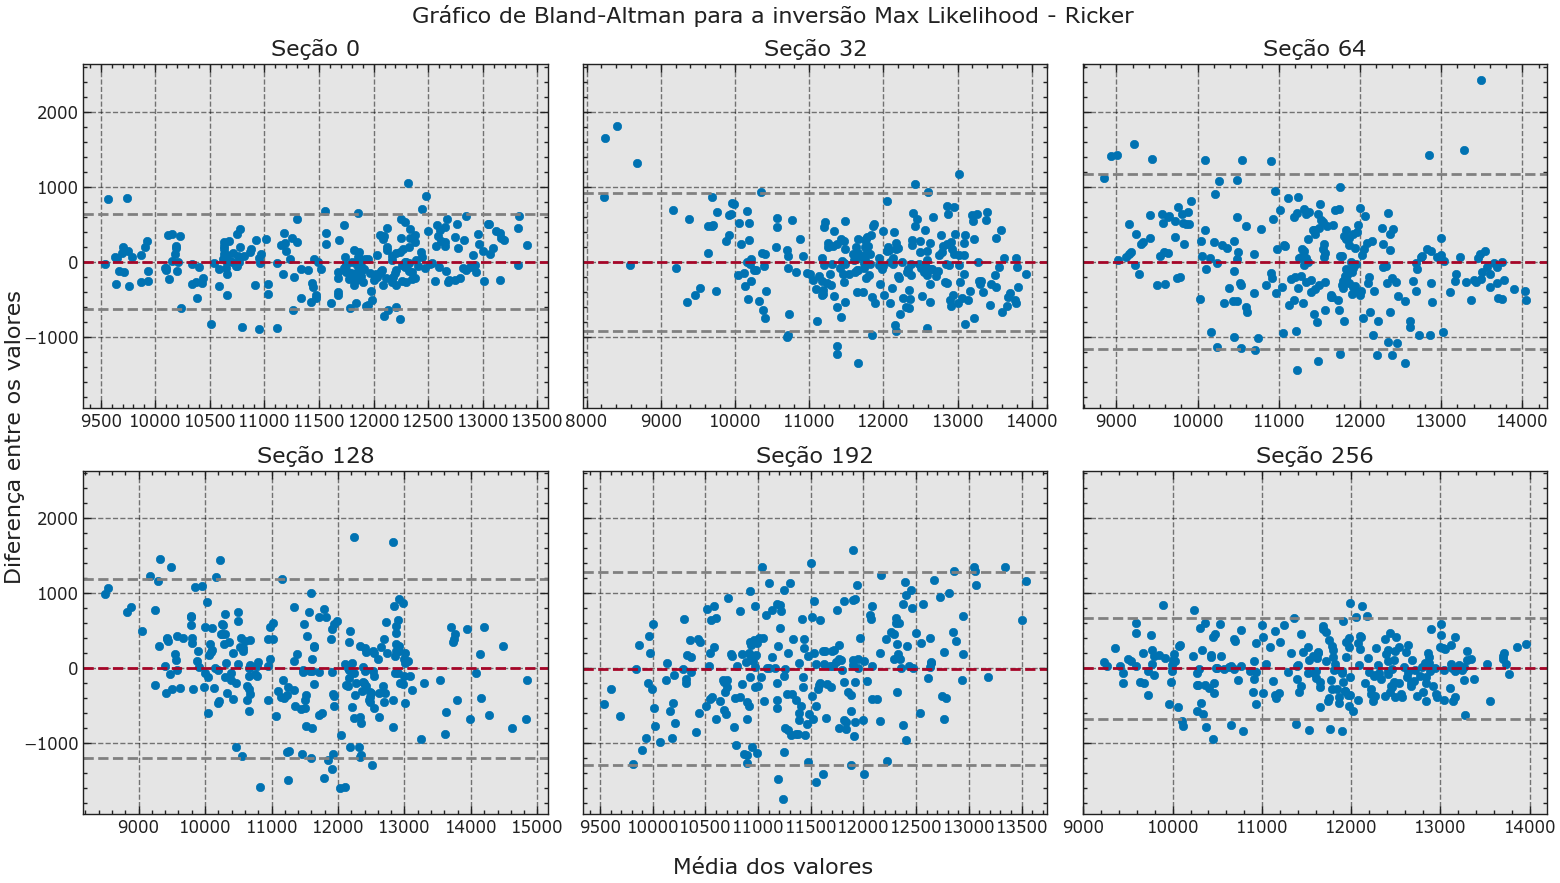

In [43]:
def plot_bland_altman(ax, mean, diff, mean_diff, std_diff, title):
    ax.scatter(mean, diff, color=PRIMARY, marker="o")
    ax.axhline(mean_diff, color=SECONDARY, linestyle="--")
    ax.axhline(mean_diff + 1.96 * std_diff, color="gray", linestyle="--")
    ax.axhline(mean_diff - 1.96 * std_diff, color="gray", linestyle="--")
    ax.set_title(title)


# 0, 32, 64, 128, 192, 256
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16, 9))
fig.suptitle(
    "Gráfico de Bland-Altman para a inversão Max Likelihood - Ricker",
    fontsize=FONT_SIZE,
)

sections = [0, 32, 64, 128, 192, 256]
for i, (ax, section) in enumerate(zip(axs.flat, sections)):
    plot_bland_altman(
        ax,
        ml_ricker_mean[i],
        ml_ricker_diff[i],
        ml_ricker_mean_diff[i],
        ml_ricker_std_diff[i],
        f"Seção {section}",
    )

fig.supxlabel("Média dos valores", fontsize=FONT_SIZE)
fig.supylabel("Diferença entre os valores", fontsize=FONT_SIZE)

# Ajuste das margens
plt.subplots_adjust(left=0.08, right=0.95, top=0.90, bottom=0.08)

plt.tight_layout()
plt.show()

# Análise de Viés

In [23]:
bias_ml_ricker = np.mean(imp_30hz.flatten() - ricker_max_likelihood.flatten())
bias_ml_butter = np.mean(imp_30hz.flatten() - butter_max_likelihood.flatten())
print(f"Viés médio: {bias_ml_ricker:.2f}")
print(f"Viés médio: {bias_ml_butter:.2f}")

Viés médio: -0.51
Viés médio: -0.51


In [24]:
bias_ss_ricker = np.mean(imp_30hz.flatten() - ricker_sparse_spike.flatten())
bias_ss_butter = np.mean(imp_30hz.flatten() - butter_sparse_spike.flatten())
print(f"Viés médio: {bias_ss_ricker:.2f}")
print(f"Viés médio: {bias_ss_butter:.2f}")

Viés médio: -0.51
Viés médio: -0.51


# R^2

In [42]:
from sklearn.metrics import r2_score

r2 = r2_score(imp_30hz.flatten(), ricker_max_likelihood.flatten())
r2_2 = r2_score(imp_30hz.flatten(), butter_max_likelihood.flatten())
print(f"R2 global entre o original e a inversão de Ricker: {r2:.2f}")
print(f"R2 global entre o original e a inversão de Butter: {r2_2:.2f}")

r2_ricker_sparse = r2_score(imp_30hz.flatten(), ricker_sparse_spike.flatten())
r2_butter_sparse = r2_score(imp_30hz.flatten(), butter_sparse_spike.flatten())
print(f"R2 global entre o original e a inversão de Ricker: {r2_ricker_sparse:.2f}")
print(f"R2 global entre o original e a inversão de Butter: {r2_butter_sparse:.2f}")

R2 global entre o original e a inversão de Ricker: 0.82
R2 global entre o original e a inversão de Butter: 0.79
R2 global entre o original e a inversão de Ricker: 0.50
R2 global entre o original e a inversão de Butter: 0.42


## ML

In [43]:
# 32, 64, 128, 196, 256
values = np.arange(0, 254, 6)

# section = 254
ml_r2_or = np.zeros(len(values))
ml_r2_ob = np.zeros(len(values))

for i, value in enumerate(values):

    ml_r2_or[i] = r2_score(
        imp_30hz[value, 128, :].flatten(),
        ricker_max_likelihood[value, 128, :].flatten(),
    )

    ml_r2_ob[i] = r2_score(
        imp_30hz[value, 128, :].flatten(),
        butter_max_likelihood[value, 128, :].flatten(),
    )

print(
    f"ML - O coeficiente de determinação R2 original e a inversão de Ricker é: {np.mean(ml_r2_or):.2f}"
)
print(
    f"ML - O coeficiente de determinação R2 original e a inversão de Butterworth é: {np.mean(ml_r2_ob):.2f}"
)

ML - O coeficiente de determinação R2 original e a inversão de Ricker é: 0.81
ML - O coeficiente de determinação R2 original e a inversão de Butterworth é: 0.78


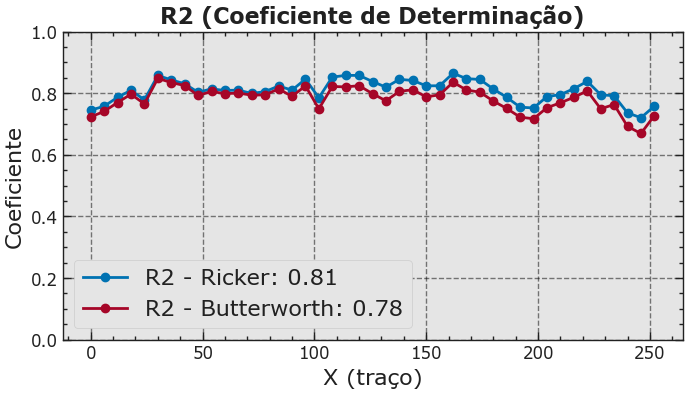

In [44]:
plt.figure(figsize=(8, 4))

plt.plot(
    values,
    ml_r2_or,
    "o-",
    label=f"R2 - Ricker: {np.mean(ml_r2_or):.2f}",
    lw=2,
    color=PRIMARY,
)
plt.plot(
    values,
    ml_r2_ob,
    "o-",
    label=f"R2 - Butterworth: {np.mean(ml_r2_ob):.2f}",
    lw=2,
    color=SECONDARY,
)


plt.title(
    f"R2 (Coeficiente de Determinação)",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)


plt.legend(loc="lower left", fontsize=FONT_SIZE)
plt.ylim(0.0, 1.00)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.ylabel("Coeficiente", fontsize=FONT_SIZE, color=TEXT_COLOR)
plt.xlabel("X (traço)", fontsize=FONT_SIZE, color=TEXT_COLOR)

# plt.savefig("simposio_figs/correlacao_pearson.png", dpi=300, bbox_inches="tight")
plt.show()

## SS

In [45]:
# 32, 64, 128, 196, 256
values = np.arange(0, 254, 6)

# section = 254
ss_r2_or = np.zeros(len(values))
ss_r2_ob = np.zeros(len(values))

for i, value in enumerate(values):

    ss_r2_or[i] = r2_score(
        imp_30hz[value, 128, :].flatten(),
        ricker_sparse_spike[value, 128, :].flatten(),
    )

    ss_r2_ob[i] = r2_score(
        imp_30hz[value, 128, :].flatten(),
        butter_sparse_spike[value, 128, :].flatten(),
    )

print(
    f"SS - O coeficiente de determinação R2 original e a inversão de Ricker é: {np.mean(ss_r2_or):.2f}"
)
print(
    f"SS - O coeficiente de determinação R2 original e a inversão de Butterworth é: {np.mean(ss_r2_ob):.2f}"
)

SS - O coeficiente de determinação R2 original e a inversão de Ricker é: 0.65
SS - O coeficiente de determinação R2 original e a inversão de Butterworth é: 0.59


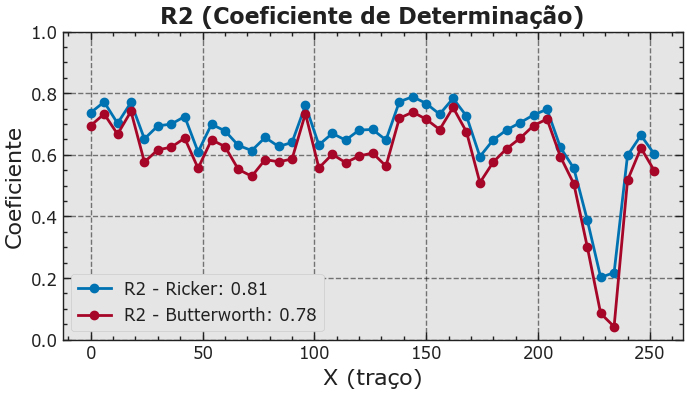

In [46]:
plt.figure(figsize=(8, 4))

plt.plot(
    values,
    ss_r2_or,
    "o-",
    label=f"R2 - Ricker: {np.mean(ml_r2_or):.2f}",
    lw=2,
    color=PRIMARY,
)
plt.plot(
    values,
    ss_r2_ob,
    "o-",
    label=f"R2 - Butterworth: {np.mean(ml_r2_ob):.2f}",
    lw=2,
    color=SECONDARY,
)


plt.title(
    f"R2 (Coeficiente de Determinação)",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)


plt.legend(loc="lower left", fontsize=FONT_SIZE-4)
plt.ylim(0, 1.00)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.ylabel("Coeficiente", fontsize=FONT_SIZE, color=TEXT_COLOR)
plt.xlabel("X (traço)", fontsize=FONT_SIZE, color=TEXT_COLOR)

# plt.savefig("simposio_figs/correlacao_pearson.png", dpi=300, bbox_inches="tight")
plt.show()